In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install statsmodels
# !pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import math

In [3]:
import tensorflow.keras as keras
from statsmodels.api import OLS
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Dense, LSTM

# Load dataset

In [4]:
with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

# Generate the dataset of all subsets

In [5]:
def work_with_nan(df):
    df = df.fillna(0)
    
    return df

In [6]:
tXY = pd.DataFrame(columns = data['MutantApeYachtClub'].columns)
tXY['collection'] = None

for i in data.keys():
    tmp = data[i].copy()
    tmp = work_with_nan(tmp)
    tmp['collection'] = i
    
    tXY = pd.concat([tXY, tmp], sort=False)

print('len of the whole dataset:', len(tXY))
tXY.head()

len of the whole dataset: 9122


,dates,prices_avg,prices_floor,prices_median,volume,marketcap,lowwatermark,amount_transactions,amount_owners,amount_sellers,...,btc adj close,btc volume,eth adj close,eth volume,sol adj close,sol volume,change in btc,change in eth,change in sol,collection
0,2022-05-01,23420.275634,0.000000,20321.779297,1.965430e+08,2.389735e+05,0.0,8392,31476.0,18,...,38469.093750,27002760110,2827.756104,15332730152,89.671509,1426749080,0.000000,0.000000,0.000000,Otherdeed
1,2022-05-02,28144.463557,0.000000,14212.331055,1.109455e+08,2.493893e+06,0.0,3942,33094.0,3,...,38529.328125,32922642426,2857.410400,18609741545,87.581017,1265220129,60.234375,29.654297,-2.090492,Otherdeed
2,2022-05-03,23819.450167,0.000000,12583.413086,3.923063e+07,1.252085e+06,0.0,1647,33520.0,4,...,37750.453125,27326943244,2783.476318,13026093219,85.842377,1011988792,-778.875000,-73.934082,-1.738640,Otherdeed
3,2022-05-04,23066.776050,0.000000,11631.999023,7.888837e+06,7.280967e+08,0.0,342,33825.0,72,...,39698.371094,36754404490,2940.644775,18186749944,92.770851,1428455342,1947.917969,157.168457,6.928474,Otherdeed
4,2022-05-05,37866.046998,9555.102539,12414.667969,5.414845e+06,8.607427e+08,0.0,143,33831.0,1057,...,36575.140625,43106256317,2749.213135,22642925048,84.596024,1805979399,-3123.230469,-191.431641,-8.174828,Otherdeed


In [7]:
with open('all data.pkl', 'wb') as f:
    pickle.dump(tXY, f)

# Feature engineering

In [8]:
tXY.head()

,dates,prices_avg,prices_floor,prices_median,volume,marketcap,lowwatermark,amount_transactions,amount_owners,amount_sellers,...,btc adj close,btc volume,eth adj close,eth volume,sol adj close,sol volume,change in btc,change in eth,change in sol,collection
0,2022-05-01,23420.275634,0.000000,20321.779297,1.965430e+08,2.389735e+05,0.0,8392,31476.0,18,...,38469.093750,27002760110,2827.756104,15332730152,89.671509,1426749080,0.000000,0.000000,0.000000,Otherdeed
1,2022-05-02,28144.463557,0.000000,14212.331055,1.109455e+08,2.493893e+06,0.0,3942,33094.0,3,...,38529.328125,32922642426,2857.410400,18609741545,87.581017,1265220129,60.234375,29.654297,-2.090492,Otherdeed
2,2022-05-03,23819.450167,0.000000,12583.413086,3.923063e+07,1.252085e+06,0.0,1647,33520.0,4,...,37750.453125,27326943244,2783.476318,13026093219,85.842377,1011988792,-778.875000,-73.934082,-1.738640,Otherdeed
3,2022-05-04,23066.776050,0.000000,11631.999023,7.888837e+06,7.280967e+08,0.0,342,33825.0,72,...,39698.371094,36754404490,2940.644775,18186749944,92.770851,1428455342,1947.917969,157.168457,6.928474,Otherdeed
4,2022-05-05,37866.046998,9555.102539,12414.667969,5.414845e+06,8.607427e+08,0.0,143,33831.0,1057,...,36575.140625,43106256317,2749.213135,22642925048,84.596024,1805979399,-3123.230469,-191.431641,-8.174828,Otherdeed


In [9]:
# label encoder
def label_encoder(df):
    label = LabelEncoder()
    df["collection"] = label.fit_transform(df["collection"])
    
    return df

In [29]:
from sklearn import preprocessing
# Normalizing the Data
def normalize(df):
    scaler = preprocessing.MinMaxScaler()
    names = df.columns
    d = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(d, columns=names)
    scaled_df.head()
    
    return scaled_df

In [13]:
tmp = tXY.copy()
tmp = tmp.drop(['prices_floor', 'prices_median', 'dates'], axis=1)
tmp = label_encoder(tmp)
tmp = tmp.astype('float32')

In [14]:
corr = tmp.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,prices_avg,volume,marketcap,lowwatermark,amount_transactions,amount_owners,amount_sellers,amount_buyers,btc adj close,btc volume,eth adj close,eth volume,sol adj close,sol volume,change in btc,change in eth,change in sol,collection
prices_avg,1.00,0.19,0.82,0.62,-0.08,-0.04,-0.07,0.19,0.10,-0.04,0.12,-0.05,0.12,0.06,-0.01,0.00,0.00,-0.13
volume,0.19,1.00,0.15,0.07,0.50,0.12,0.15,0.22,0.07,-0.00,0.08,0.01,0.04,0.04,-0.00,0.02,0.03,-0.09
marketcap,0.82,0.15,1.00,0.55,-0.08,0.08,-0.04,0.18,0.08,-0.06,0.10,-0.06,0.09,0.05,-0.00,0.00,0.00,-0.12
lowwatermark,0.62,0.07,0.55,1.00,-0.05,-0.05,-0.06,0.04,0.00,-0.03,0.00,-0.02,-0.02,0.00,0.01,0.01,0.01,-0.11
amount_transactions,-0.08,0.50,-0.08,-0.05,1.00,0.08,0.65,0.06,-0.03,-0.01,-0.04,0.01,-0.06,-0.03,0.00,0.01,0.01,-0.02
amount_owners,-0.04,0.12,0.08,-0.05,0.08,1.00,0.11,0.03,-0.04,-0.06,0.00,-0.07,0.01,0.01,-0.01,-0.01,-0.01,-0.01
amount_sellers,-0.07,0.15,-0.04,-0.06,0.65,0.11,1.00,0.03,-0.10,-0.03,-0.07,-0.03,-0.05,0.00,-0.00,-0.01,-0.01,0.00
amount_buyers,0.19,0.22,0.18,0.04,0.06,0.03,0.03,1.00,0.08,0.01,0.09,0.04,0.07,0.02,0.00,0.01,0.02,-0.05
btc adj close,0.10,0.07,0.08,0.00,-0.03,-0.04,-0.10,0.08,1.00,0.09,0.92,0.02,0.84,0.30,0.09,0.15,0.16,-0.09
btc volume,-0.04,-0.00,-0.06,-0.03,-0.01,-0.06,-0.03,0.01,0.09,1.00,-0.01,0.85,-0.05,0.31,-0.15,-0.18,-0.15,-0.08


# Models

## Linear Regression 

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score

In [15]:
tmp.head()

,prices_avg,volume,marketcap,lowwatermark,amount_transactions,amount_owners,amount_sellers,amount_buyers,btc adj close,btc volume,eth adj close,eth volume,sol adj close,sol volume,change in btc,change in eth,change in sol,collection
0,23420.275391,196542960.0,2.389735e+05,0.0,8392.0,31476.0,18.0,8.000000,38469.093750,2.700276e+10,2827.756104,1.533273e+10,89.671509,1.426749e+09,0.000000,0.000000,0.000000,55.0
1,28144.462891,110945472.0,2.493893e+06,0.0,3942.0,33094.0,3.0,9.000000,38529.328125,3.292264e+10,2857.410400,1.860974e+10,87.581017,1.265220e+09,60.234375,29.654297,-2.090492,55.0
2,23819.449219,39230636.0,1.252085e+06,0.0,1647.0,33520.0,4.0,2.000000,37750.453125,2.732694e+10,2783.476318,1.302609e+10,85.842377,1.011989e+09,-778.875000,-73.934082,-1.738640,55.0
3,23066.775391,7888837.5,7.280967e+08,0.0,342.0,33825.0,72.0,2.000000,39698.371094,3.675440e+10,2940.644775,1.818675e+10,92.770851,1.428455e+09,1947.917969,157.168457,6.928474,55.0
4,37866.046875,5414844.5,8.607427e+08,0.0,143.0,33831.0,1057.0,4.333333,36575.140625,4.310625e+10,2749.213135,2.264293e+10,84.596024,1.805979e+09,-3123.230469,-191.431641,-8.174828,55.0


In [96]:
tmp_reg = tmp.copy()
tmp_reg = normalize(tmp_reg)

X = tmp_reg.drop(['prices_avg'], axis = 1).copy()
y = tmp_reg['prices_avg'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat = lm.predict(X_test) 

y_pred = lm.predict(X_test)
print('R^2:  ', lm.score(X_train, y_train))
print('MAE:  ', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:  ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))

R^2:   0.7404615549757583
MAE:   0.015887193
MSE:   0.0011819665
RMSE:  0.12604441


## Lasso 

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [98]:
X = tmp_reg.drop(['prices_avg'], axis = 1).copy()
y = tmp_reg['prices_avg'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1).fit(X_train, y_train)
get_cv_scores(lasso)

CV Mean:  -0.0008108243628142553
STD:  0.0009831231643095606




In [99]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=3)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  0.7504391938830002
Best Params:  {'alpha': 1e-05}


In [93]:
reg = Lasso(alpha=grid_result.best_params_['alpha'])
reg.fit(X_train, y_train)

print('R^2  ', round(reg.score(X_train, y_train)*100, 2))
print('R^2  ', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE: ', round(mse_train, 4))

# Test data
pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE: ', round(mse_test, 4))

R^2   74.66
R^2   69.17
MSE:  0.001
MSE:  0.0013


## LSTM

In [254]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import r2_score

In [255]:
tmp.head()

,prices_avg,volume,marketcap,lowwatermark,amount_transactions,amount_owners,amount_sellers,amount_buyers,btc adj close,btc volume,eth adj close,eth volume,sol adj close,sol volume,change in btc,change in eth,change in sol,collection
0,23420.275391,196542960.0,2.389735e+05,0.0,8392.0,31476.0,18.0,8.000000,38469.093750,2.700276e+10,2827.756104,1.533273e+10,89.671509,1.426749e+09,0.000000,0.000000,0.000000,55.0
1,28144.462891,110945472.0,2.493893e+06,0.0,3942.0,33094.0,3.0,9.000000,38529.328125,3.292264e+10,2857.410400,1.860974e+10,87.581017,1.265220e+09,60.234375,29.654297,-2.090492,55.0
2,23819.449219,39230636.0,1.252085e+06,0.0,1647.0,33520.0,4.0,2.000000,37750.453125,2.732694e+10,2783.476318,1.302609e+10,85.842377,1.011989e+09,-778.875000,-73.934082,-1.738640,55.0
3,23066.775391,7888837.5,7.280967e+08,0.0,342.0,33825.0,72.0,2.000000,39698.371094,3.675440e+10,2940.644775,1.818675e+10,92.770851,1.428455e+09,1947.917969,157.168457,6.928474,55.0
4,37866.046875,5414844.5,8.607427e+08,0.0,143.0,33831.0,1057.0,4.333333,36575.140625,4.310625e+10,2749.213135,2.264293e+10,84.596024,1.805979e+09,-3123.230469,-191.431641,-8.174828,55.0


In [256]:
tmp_lstm = tmp.copy()
tmp_lstm = normalize(tmp_lstm)
# tmp_lstm = tmp_lstm.sample(frac=1).reset_index(drop=True)
X = tmp_lstm.drop(['prices_avg'], axis = 1).copy()
y = tmp_lstm['prices_avg'].copy()

In [257]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [258]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(y, WINDOW_SIZE)
X1.shape, y1.shape

((9117, 5, 1), (9117,))

In [259]:
X_train, y_train = X1[:6500], y1[:6500]
X_val, y_val = X1[6500:7000], y1[6500:7000]
X_test, y_test = X1[7000:], y1[7000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6500, 5, 1), (6500,), (500, 5, 1), (500,), (2117, 5, 1), (2117,))

In [260]:
model = Sequential([layers.InputLayer(X_train.shape[1:]),
                        layers.LSTM(128, return_sequences=True),
                        layers.Dropout(0.2),
                        layers.LSTM(128, return_sequences=False),
                        layers.Dropout(0.2),
                        layers.Dense(64, kernel_initializer='uniform', activation='relu'),
                        layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_2734"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9040 (LSTM)             (None, 5, 128)            66560     
_________________________________________________________________
dropout_9015 (Dropout)       (None, 5, 128)            0         
_________________________________________________________________
lstm_9041 (LSTM)             (None, 128)               131584    
_________________________________________________________________
dropout_9016 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_7257 (Dense)           (None, 64)                8256      
_________________________________________________________________
dense_7258 (Dense)           (None, 1)                 65        
Total params: 206,465
Trainable params: 206,465
Non-trainable params: 0
_____________________________________________

In [261]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
204/204 [==============================] - 5s 10ms/step - loss: 8.4092e-04 - mean_absolute_error: 0.0136 - val_loss: 2.2113e-05 - val_mean_absolute_error: 0.0038
Epoch 2/10
204/204 [==============================] - 2s 7ms/step - loss: 3.6589e-04 - mean_absolute_error: 0.0094 - val_loss: 8.0288e-05 - val_mean_absolute_error: 0.0085
Epoch 3/10
204/204 [==============================] - 2s 7ms/step - loss: 3.4078e-04 - mean_absolute_error: 0.0091 - val_loss: 5.5811e-05 - val_mean_absolute_error: 0.0054
Epoch 4/10
204/204 [==============================] - 1s 7ms/step - loss: 3.6461e-04 - mean_absolute_error: 0.0096 - val_loss: 1.6517e-05 - val_mean_absolute_error: 0.0033
Epoch 5/10
204/204 [==============================] - 2s 7ms/step - loss: 3.5539e-04 - mean_absolute_error: 0.0096 - val_loss: 1.9988e-05 - val_mean_absolute_error: 0.0029
Epoch 6/10
204/204 [==============================] - 2s 7ms/step - loss: 3.3908e-04 - mean_absolute_error: 0.0094 - val_loss: 2.4924e-05 -

R^2 train:  0.9258069345657185
MSE train:  0.00031011918


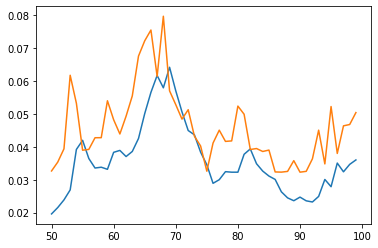

R^2 test:  0.5476956828142878
MSE test:  0.0006129492


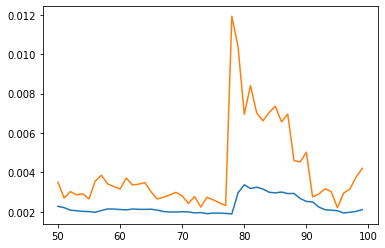

In [268]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
print('R^2 train: ', r2_score(train_results['Train Predictions'], train_results['Actuals']))
print('MSE train: ', mean_squared_error(train_results['Train Predictions'], train_results['Actuals']))
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.show()


train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
print('R^2 test: ', r2_score(train_results['Train Predictions'], train_results['Actuals']))
print('MSE test: ', mean_squared_error(train_results['Train Predictions'], train_results['Actuals']))
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [184]:
# def define_model(learning_rate=0.001, dropout_rate=0.2, activation='relu', init_weights='uniform'): 
#     model = Sequential([layers.InputLayer(X_train.shape[1:]),
#                         layers.LSTM(128, return_sequences=True),
#                         layers.Dropout(dropout_rate),
#                         layers.LSTM(128, return_sequences=False),
#                         layers.Dropout(dropout_rate),
#                         layers.Dense(64, kernel_initializer=init_weights, activation=activation),
#                         layers.Dense(1)])

#     model.compile(loss='mse', 
#                   optimizer=Adam(learning_rate=learning_rate),
#                   metrics=['mean_absolute_error'])
    
#     return model

# batch_size = 10
# epochs = 10
# model = KerasClassifier(build_fn=define_model, 
#                         epochs=epochs, 
#                         batch_size = batch_size, 
#                         verbose=1)

# # activation = ['softmax', 'relu']
# # init_weights = ['uniform', 'normal', 'linear']
# # dropout_rate = [0.0,  0.2, 0.4]
# # batch_size = [10, 50, 100]
# # epochs = [1, 5, 10]

# activation = ['softmax']
# init_weights = ['uniform', 'normal']
# dropout_rate = [0.0,  0.2]
# batch_size = [10, 50]
# epochs = [10]

# param_grid = dict(activation=activation, 
#                   init_weights=init_weights,
#                   dropout_rate=dropout_rate,
#                   batch_size=batch_size, 
#                   epochs=epochs)

# # x_grid, x_not_use, y_grid, y_not_use = train_test_split(X_train, y_train, test_size=0.9, random_state=42)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=5)

# grid_result = grid.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))